In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import matplotlib

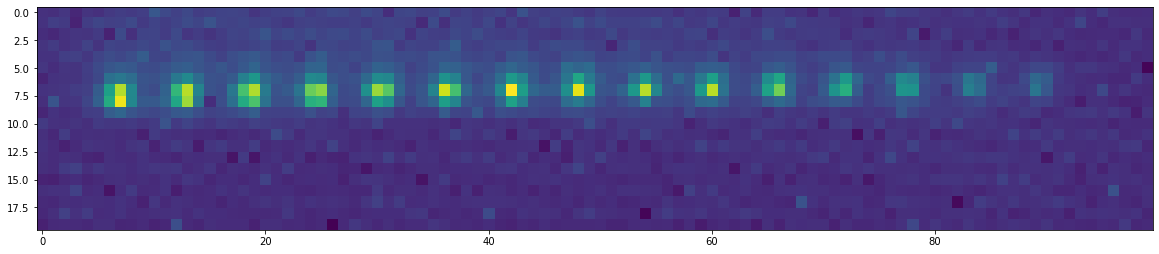

In [283]:
data = np.load('NUVU399imaging.npz')
img_width, img_height = data['nuvuImage'].shape[2], data['nuvuImage'].shape[3]
images = np.reshape(data['nuvuImage'], (np.prod(data['nuvuImage'].shape[0:2]), img_width, img_height))
avg_img = np.transpose(np.sum(images, axis=0))
plt.figure(figsize=(20,20))
plt.imshow(avg_img[:,100:])

plt.show()

# Some Preliminary Analysis
First I take a two-dimensional Fourier Transform of the image to get an understading of what the lattice constant is in the x-direction. The frequency with the greatest power corresponds to the reciprocal lattice constant. Turns out the frequency with the most power is zero, which corresponds to the background in the image. The next highest peak occurs at 0.17/px, which corresponds to a lattice constant of about 5.88 px. This seems to agree quite well with visual observations as well as in Jeff's other analysis notebook (there its taken to be 5.9 px). As for the decrease in the y-direction of the lattice, the Fourier Transform isn't sensitive enough to the small change due to resolution limits. 

Another thing to note is that the spectral content seems to suggest that half of the image is empty, which we get from the power in the first frequency bin.

Finding the lattice constant is important, as this will allow us to determine how many sites there are in total, and how large of an area they should correspond to.

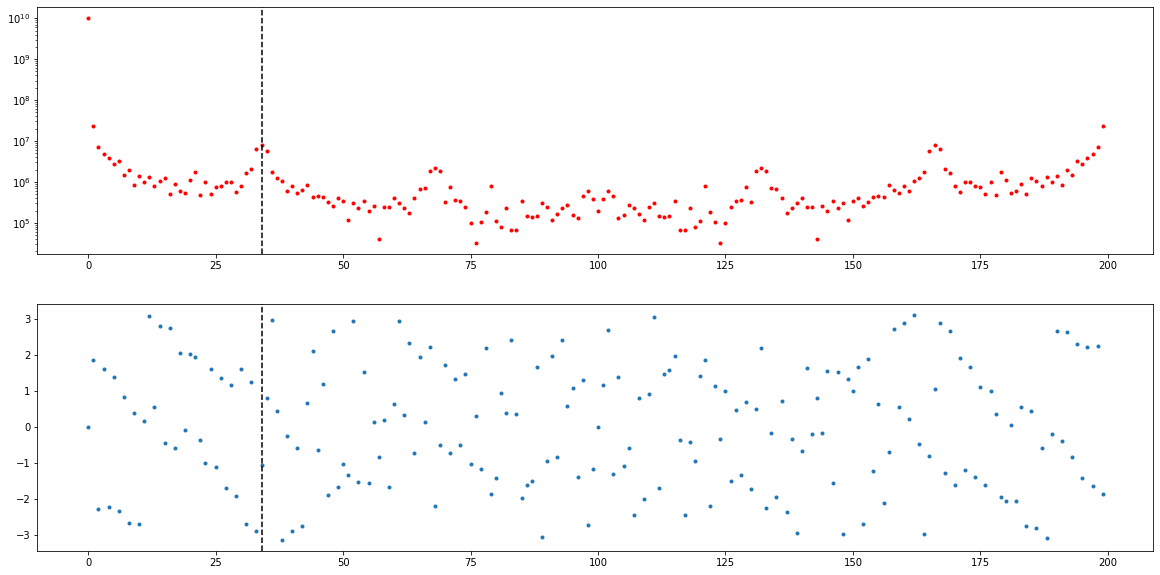

frequency: 0.17 / px; phase: -1.058 rad
Lattice constant: 5.882 px; Offset: -0.991px


In [284]:
spectral_content = np.fft.fft2(avg_img)

fig, axs = plt.subplots(2, 1, figsize=(20,10))

axs[0].plot(np.absolute(spectral_content[0]), 'r.')
axs[0].set_yscale('log')
axs[0].axvline(34, color='k', linestyle='--')
axs[1].plot(np.angle(spectral_content[0]), '.')
axs[1].axvline(34, color='k', linestyle='--')
plt.show()

print(f"frequency: {34 / 200} / px; phase: {np.angle(spectral_content[0][34]):.3f} rad")
lattice_constant = 200 / 34
lattice_offset = np.angle(spectral_content[0][34]) * lattice_constant / (2 * np.pi)
print(f"Lattice constant: {lattice_constant:.3f} px; Offset: {lattice_offset:.3f}px")

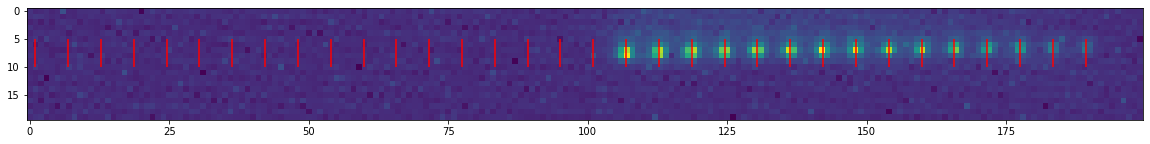

In [285]:
n_sites = int(200 // lattice_constant)

plt.figure(figsize=(20,5))
plt.imshow(avg_img)
plt.vlines(np.arange(n_sites) * lattice_constant - lattice_offset, 5, 10, color='r', linestyle='-')

plt.show()

Since there is only a line of atoms, it is very difficult to find out the lattice constant in the vertical direction using a Fourier Transform. Instead I'll try to fit a Gaussian to the brightness distribution for the cross section at the x-coordinate of the lattice sites, then try to find the change in the center on the y-axis of the centers along the x-axis. 

[[ 7.37492904e+00  1.19456754e+00  1.33428991e+05  2.46766978e+06]
 [ 7.24896208e+00  1.07006378e+00  1.41475415e+05  2.47544311e+06]
 [ 7.19265329e+00  1.05897612e+00  1.57814091e+05  2.47230914e+06]
 [ 7.12332181e+00  1.09574774e+00  1.72164857e+05  2.47011862e+06]
 [ 7.05834021e+00  9.64160108e-01  1.82995729e+05  2.47542033e+06]
 [ 7.03170230e+00  9.59673714e-01  2.01374066e+05  2.47283293e+06]
 [ 6.99528550e+00  9.02523117e-01  2.27223928e+05  2.47047817e+06]
 [ 6.83011189e+00  8.07268377e-01  2.16008109e+05  2.47638174e+06]
 [ 6.74472365e+00  1.01461700e+00  9.52760975e+04  2.47172367e+06]
 [ 6.75209326e+00  1.11730885e+00  1.02679193e+05  2.46994423e+06]
 [ 6.61026336e+00  9.52130220e-01  1.21037317e+05  2.47076800e+06]
 [ 6.70462965e+00  1.07252118e+00  9.42758928e+04  2.46854003e+06]
 [ 6.62821395e+00  1.07535379e+00  1.02839046e+05  2.47056895e+06]
 [ 6.56161686e+00 -8.30872824e-01  8.71466739e+04  2.46923830e+06]
 [ 6.59355277e+00  9.27811228e-01  7.18745313e+04  2.46653050e

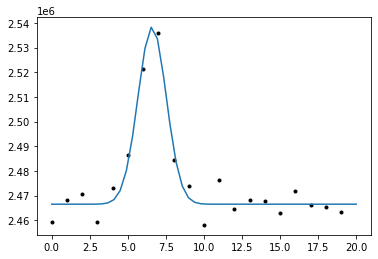

In [286]:
x_lattice_sites = np.arange(n_sites) * lattice_constant - lattice_offset
lattice_cross_sections = np.array([avg_img[:,int(i)] for i in x_lattice_sites])

def gaussian(x, mu, sigma, a, b):
    return a * np.exp(- 1 / 2 * ((x - mu) / sigma) ** 2) + b


params = np.empty((15, 4))
for i, cross_section in enumerate(lattice_cross_sections[-15:]):
    params[i], err = opt.curve_fit(gaussian, np.arange(0, 20), cross_section, maxfev = int(1e4))
    
    
print(params)    

site = 14
plt.plot(lattice_cross_sections[-15 + site], 'k.')
plt.plot(np.linspace(0, 20), gaussian(np.linspace(0, 20), *params[site]))

plt.show()

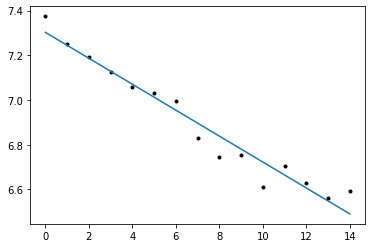

-0.058016717674562436


In [287]:
slope, intercept = np.polyfit(np.arange(15), params[:,0], 1)

plt.plot(params[:, 0], 'k.')
plt.plot(np.arange(15), slope * np.arange(15) + intercept)
plt.show()

print(slope)

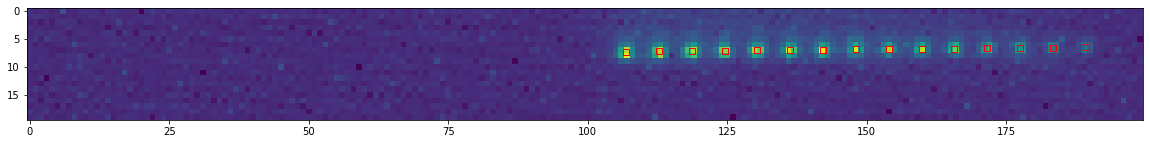

In [288]:
plt.figure(figsize=(20,5))
plt.imshow(avg_img)
plt.plot((18 + np.arange(15)) * lattice_constant - lattice_offset, np.arange(15) * slope + intercept, 'rs', fillstyle='none')

plt.show()

In [289]:
lattice_vec = np.array([lattice_constant, slope])
lattice_offset = np.array([lattice_offset, intercept])

print(lattice_offset)

[-0.99065481  7.30281033]


# Playing Around with Some Machine Learning Stuff

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers

In [291]:
#import data
data = np.load('generated_data.npz')

img_width, img_height = data['nuvuImage'].shape[2], data['nuvuImage'].shape[3]
images = np.reshape(data['nuvuImage'], (np.prod(data['nuvuImage'].shape[0:2]), img_width, img_height))
images = images[:,100:,:15]
images /= np.max(images)

occupancies = np.swapaxes(data['occupancy'], 1, 2)
labels = occupancies.reshape(-1, occupancies.shape[-1])

dataset = tf.data.Dataset.from_tensor_slices((images, labels))

KeyError: 'nuvuImage is not a file in the archive'

In the cell above I'm trying to make the occupancy the label for each image. I'm not sure how this will work with the neural network as typically the thing is supposed to spit out just one value, not an entire array of values. 

For my network I'll start off with two convolutional layers followed by a fully connected layer. For the convolutional layers I'll use eight 10x10 kernels with stride two.

In [292]:
model = models.Sequential()
model.add(layers.Input(shape=(100, 15, 1)))
model.add(layers.Conv2D(16, (3, 3), strides=1, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(16, (6, 6), strides=1, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(15, activation='sigmoid'))

model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 98, 13, 16)        160       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 49, 6, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 44, 1, 16)         9232      
                                                                 
 flatten_26 (Flatten)        (None, 704)               0         
                                                                 
 dense_40 (Dense)            (None, 15)                10575     
                                                                 
Total params: 19,967
Trainable params: 19,967
Non-trainable params: 0
_________________________________________________

In [293]:
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(images, labels, epochs=10)

Epoch 1/10


ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_60" is incompatible with the layer: expected shape=(None, 100, 15, 1), found shape=(None, 200, 20)


In [294]:
image_index = np.random.randint(0, images.shape[0])

print(model(np.expand_dims([images[image_index]], axis=3)))

print(labels[image_index])

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(images[image_index]))
plt.show()

ValueError: Input 0 of layer "sequential_60" is incompatible with the layer: expected shape=(None, 100, 15, 1), found shape=(1, 200, 20, 1)

## Using the generated dataset

In [306]:
data = np.load('generated_data.npz')

(50000, 15)


In [378]:
model = models.Sequential()
model.add(layers.Input(shape=(128, 16, 1)))
model.add(layers.Conv2D(8, (8, 8), strides=1, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(8, (4, 4), strides=1, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(15, activation='sigmoid'))

model.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_182 (Conv2D)         (None, 121, 9, 8)         520       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 60, 4, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_183 (Conv2D)         (None, 57, 1, 8)          1032      
                                                                 
 flatten_56 (Flatten)        (None, 456)               0         
                                                                 
 dense_70 (Dense)            (None, 15)                6855      
                                                                 
Total params: 8,407
Trainable params: 8,407
Non-trainable params: 0
___________________________________________________

In [379]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(data['arr_0'], data['arr_1'], epochs=10)

Epoch 1/10
1563/1563 [==============================] - 18s 10ms/step - loss: 0.6934 - accuracy: 0.0929
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6933 - accuracy: 0.1330
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6934 - accuracy: 0.1080
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6934 - accuracy: 0.1072
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6934 - accuracy: 0.1278
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.6934 - accuracy: 0.1618
Epoch 7/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6934 - accuracy: 0.0807
Epoch 8/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6934 - accuracy: 0.1281
Epoch 9/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6934 - accuracy: 0.1264
Epoch 10/10
1563/1563 [==============================] - 15s 10m

tf.Tensor(
[[7.8080773e-01 8.0894154e-01 9.9999994e-01 7.8407967e-01 1.5161349e-04
  1.6072968e-03 9.9813318e-01 9.9999964e-01 9.9995315e-01 9.9997693e-01
  8.6879689e-04 1.8382769e-04 9.9999970e-01 1.7871631e-02 9.9966282e-01]], shape=(1, 15), dtype=float32)
[1 1 1 1 0 0 1 1 1 1 0 0 1 0 1]


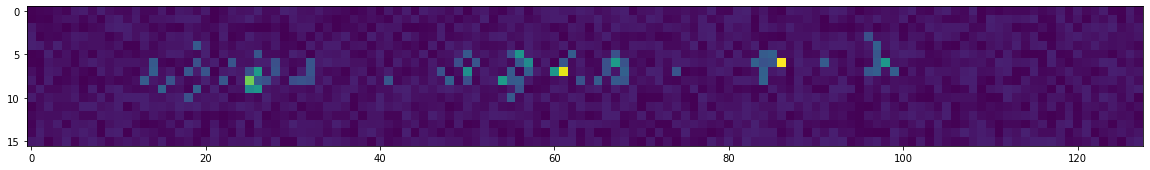

In [351]:
image_index = np.random.randint(0, data['arr_0'].shape[0])

print(model(np.expand_dims([data['arr_0'][image_index]], axis=3)))

print(data['arr_1'][image_index])

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(data['arr_0'][image_index]))
plt.show()

## Trying With a Single Lattice Site

In [250]:
training = np.load('training.npz')
testing = np.load('testing.npz')

model = models.Sequential()
model.add(layers.Input(shape=(16, 16, 1)))
model.add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 14, 14, 8)         80        
                                                                 
 flatten_33 (Flatten)        (None, 1568)              0         
                                                                 
 dense_37 (Dense)            (None, 1)                 1569      
                                                                 
Total params: 1,649
Trainable params: 1,649
Non-trainable params: 0
_________________________________________________________________


In [254]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(training['images'], training['occupancies'], epochs=100)

Epoch 1/100
157/157 [==============================] - 1s 2ms/step - loss: 0.0087 - binary_accuracy: 0.9984
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0084 - binary_accuracy: 0.9978
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0104 - binary_accuracy: 0.9970
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0081 - binary_accuracy: 0.9990
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0091 - binary_accuracy: 0.9980
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0084 - binary_accuracy: 0.9982
Epoch 7/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0098 - binary_accuracy: 0.9976
Epoch 8/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0085 - binary_accuracy: 0.9982
Epoch 9/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0079 - binary_accuracy: 0.9988
Epoch 10/100
157/157 [======

157/157 [==============================] - 0s 2ms/step - loss: 0.0042 - binary_accuracy: 0.9998
Epoch 77/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0057 - binary_accuracy: 0.9986
Epoch 78/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0036 - binary_accuracy: 1.0000
Epoch 79/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0036 - binary_accuracy: 0.9998
Epoch 80/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0033 - binary_accuracy: 1.0000
Epoch 81/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0042 - binary_accuracy: 0.9996
Epoch 82/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0034 - binary_accuracy: 0.9998
Epoch 83/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0034 - binary_accuracy: 1.0000
Epoch 84/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0035 - binary_accuracy: 1.0000
Epoch 85/100
157/157 [==========

In [258]:
model.evaluate(testing['images'], testing['occupancies'])

16/16 [==============================] - 0s 1ms/step - loss: 0.1259 - binary_accuracy: 0.9760


[0.12587502598762512, 0.9760000109672546]

tf.Tensor([[2.5507894e-12]], shape=(1, 1), dtype=float32)
[0]


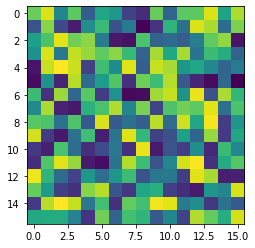

In [180]:
image_index = np.random.randint(0, data['images'].shape[0])

print(model(np.expand_dims([data['images'][image_index]], axis=3)))

print(data['occupancies'][image_index])

plt.imshow(np.transpose(data['images'][image_index]))
plt.show()

We can actually see what the learned kernels are, which would be quite telling! It would also be useful to see them to interpret what our model has "learned".

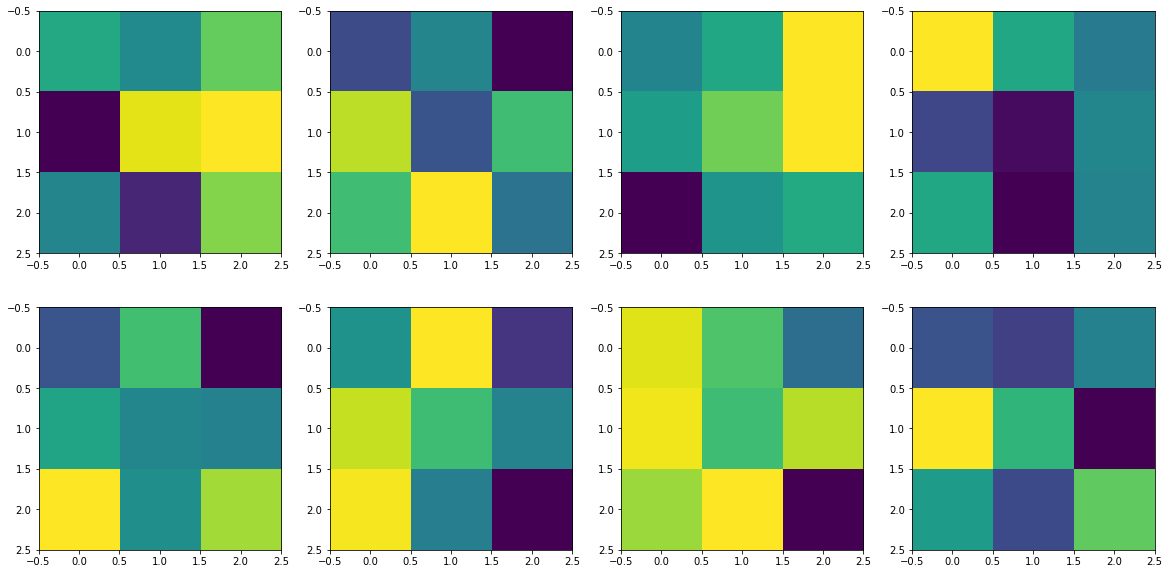

In [259]:
kernels = model.layers[0].kernel

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i in range(2):
    for j in range(4):
        axs[i, j].imshow(kernels[:, :, 0, 4 * i + j])
    
plt.show()

## Three Lattice Sites

In [319]:
training = np.load('training.npz')
testing = np.load('testing.npz')

model = models.Sequential()
model.add(layers.Input(shape=(64, 64, 1)))
model.add(layers.Conv2D(8, (3, 3), strides=1, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(8, (7, 7), strides=1, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='sigmoid'))

model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 62, 62, 8)         80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 8)        0         
 2D)                                                             
                                                                 
 conv2d_64 (Conv2D)          (None, 25, 25, 8)         3144      
                                                                 
 flatten_48 (Flatten)        (None, 5000)              0         
                                                                 
 dense_52 (Dense)            (None, 3)                 15003     
                                                                 
Total params: 18,227
Trainable params: 18,227
Non-trainable params: 0
_________________________________________________

In [320]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(training['images'], training['occupancies'], epochs=40)

Epoch 1/40
125/125 [==============================] - 4s 30ms/step - loss: 0.7016 - binary_accuracy: 0.4883
Epoch 2/40
125/125 [==============================] - 4s 29ms/step - loss: 0.6932 - binary_accuracy: 0.4978
Epoch 3/40
125/125 [==============================] - 4s 29ms/step - loss: 0.6932 - binary_accuracy: 0.4903
Epoch 4/40
125/125 [==============================] - 3s 26ms/step - loss: 0.6932 - binary_accuracy: 0.4912
Epoch 5/40
125/125 [==============================] - 4s 30ms/step - loss: 0.6932 - binary_accuracy: 0.4897
Epoch 6/40
125/125 [==============================] - 4s 30ms/step - loss: 0.6932 - binary_accuracy: 0.4935
Epoch 7/40
 57/125 [============>.................] - ETA: 2s - loss: 0.6932 - binary_accuracy: 0.4993

KeyboardInterrupt: 

In [317]:
model.evaluate(testing['images'], testing['occupancies'])

13/13 [==============================] - 0s 5ms/step - loss: 0.6918 - binary_accuracy: 0.7517


[0.6917994618415833, 0.7516667246818542]

tf.Tensor([[0.80628884 0.99979895 0.15297045]], shape=(1, 3), dtype=float32)
[0. 1. 1.]


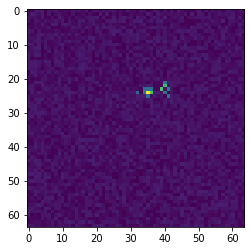

In [318]:
image_index = np.random.randint(0, testing['images'].shape[0])

print(model(np.expand_dims([testing['images'][image_index]], axis=3)))

print(testing['occupancies'][image_index])

plt.imshow(np.transpose(testing['images'][image_index]))
plt.show()